# **Data Processing**

This notebook documents the steps taken to process the Empatica E4 data from the format downloaded using SeerPy to the format which will be used to train the neural models.

# Patients

The following cell contains the patients for which E4 data exists, as well as a list of all patients.

In [ ]:
patient_ids = [
    'MSEL_00095',
    'MSEL_00172',
    'MSEL_00182',
    'MSEL_00501',
    'MSEL_00502',
    'MSEL_00764',
    'MSEL_01097',
    'MSEL_01110-ICU',
    'MSEL_01462',
    'MSEL_01550',
    'MSEL_01575',
    'MSEL_01676',
    'MSEL_01709',
    'MSEL_01763',
    'MSEL_01808',
    'MSEL_01828',
    'MSEL_01832',
    'MSEL_01836',
    'MSEL_01838',
    'MSEL_01842',
    'MSEL_01844',
    'MSEL_01849',
    'MSEL_01853',
    'MSEL_01870']

# all_patient_ids = [p[10:] for p in glob("data\data\*")]

# Handling Accelerometery Data

Any given channel from a patient's data can be loaded easily.

In [ ]:
import json
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from math import ceil
from glob import glob
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

In [ ]:
# labels = {k:0 for k in sorted(pd.concat([pd.read_csv(f) for f in glob("data\data\*\*_labels.csv")])["labels.note"].unique())}
# with open("labels.json", "w") as f:
#     json.dump(labels, f, indent=4)

In [ ]:
from shutil import copy

In [ ]:
## Make directoriees for accelerometry data if they don't exist
# for patient_id in patient_ids:
#     os.mkdir(f"data\data\{patient_id}\Empatica-ACC x")
#     os.mkdir(f"data\data\{patient_id}\Empatica-ACC y")
#     os.mkdir(f"data\data\{patient_id}\Empatica-ACC z")

## Copy acc data to directory
# for patient_id in patient_ids:
#     x = glob(f"data\data\{patient_id}\Empatica-ACC\{patient_id}_Empatica-ACC_Acc x_segment_*.parquet")
#     y = glob(f"data\data\{patient_id}\Empatica-ACC\{patient_id}_Empatica-ACC_Acc y_segment_*.parquet")
#     z = glob(f"data\data\{patient_id}\Empatica-ACC\{patient_id}_Empatica-ACC_Acc z_segment_*.parquet")
#     for f in x:
#         copy(f, f"data\\data\\{patient_id}\\Empatica-ACC x")
#     for f in y:
#         copy(f, f"data\\data\\{patient_id}\\Empatica-ACC y")
#     for f in z:
#         copy(f, f"data\\data\\{patient_id}\\Empatica-ACC z")

# Writing Patient Data Files

In [ ]:
# Channels which we are using for preictions
channels = ["ACC x", "ACC y", "ACC z", "BVP", "EDA", "TEMP"]

# For each patient
for patient_id in tqdm(patient_ids):
    # Get the start time of the patients recording
    labels = pd.read_csv(f"data\data\{patient_id}\{patient_id}_labels.csv")
    start_time = labels["startTime"][0]

    # Create dataframe to store patients data
    patient_data = pd.DataFrame()

    ## Load all of the patient's data from each channel
    for channel in channels:
        # Load the data for current patient and channel
        channel_data = pd.read_parquet(f"data\data\{patient_id}\Empatica-{channel}")
        
        # Use time column as index for the channel data
        channel_data = channel_data.set_index("time")

        # Add the channel data to the patients recording data
        patient_data[channel] = channel_data["data"]

    # Fix index so that recording starts at t=0
    patient_data.index = patient_data.index - start_time

    # Add missing indexes and fill with NAs
    patient_data = patient_data.reindex(np.arange(0, ceil(patient_data.index.max()), 7.8125))

    # Save the patient's recording data to parquet
    patient_data.to_parquet(f"data\{patient_id}_128Hz.parquet")

# Scaling Channel Data

In [ ]:
## Calculate min and max values for each channel
max_values = pd.DataFrame(columns = ["ACC x", "ACC y", "ACC z", "BVP", "EDA", "TEMP"])
min_values = pd.DataFrame(columns = ["ACC x", "ACC y", "ACC z", "BVP", "EDA", "TEMP"])
for patient_id in patient_ids:
    data = pd.read_parquet(f"data\{patient_id}_128Hz.parquet")
    max_values.loc[patient_id, ["ACC x", "ACC y", "ACC z", "BVP", "EDA", "TEMP"]] = data.max()
    min_values.loc[patient_id, ["ACC x", "ACC y", "ACC z", "BVP", "EDA", "TEMP"]] = data.min()

min_value = min_values.min()
max_value = max_values.max()

# Scale each patients data
for patient_id in tqdm(patient_ids):
    data = pd.read_parquet(f"data\{patient_id}_128Hz.parquet")
    scaled = (data - min_value) / (max_value - min_value)
    scaled.to_parquet(f"data\{patient_id}_128Hz_scaled.parquet")

# Writing Segments

In [ ]:
from scipy.signal import decimate

In [271]:
# Make directoriees for segment_data
for patient_id in patient_ids:
    os.makedirs(f"data/segments/{patient_id}/preictal")
    os.makedirs(f"data/segments/{patient_id}/interictal")


In [272]:
# Turn off SettingWithCopyWarning
pd.options.mode.chained_assignment = None

# patient_ids = ["MSEL_01844"]
for patient_id in patient_ids:
    print(f"Writing segments for patient: {patient_id}")

    # Load patient's recording and remove first and last hour
    patient_data = pd.read_parquet(f"data\{patient_id}_128Hz_scaled.parquet")
    patient_data = patient_data.iloc[460800:-460800]

    # If the patient's recording is less than 2hr they will have no data. TF move to next patient
    if not patient_data.any(axis=None):
        continue

    # Load the annotation for the patients recording
    labels = pd.read_csv(f"data\data\{patient_id}\{patient_id}_labels.csv")

    # Labels may be annotated when the recording does not exist or in first or last hour. TF remove labels for which there is no recording.
    labels = labels[labels["labels.startTime"] - labels["startTime"]<patient_data.index[-1]]
    
    # Recording start time 
    start_time = labels["startTime"][0]

    # Calculate end time of each clinical event (seizures including subclinical ones)
    labels["labels.endTime"] = labels["labels.startTime"] + labels["labels.duration"]

    # label_notes contains bool of whether label corresponds to seizure or not
    with open("labels.json") as f:
        label_notes = json.load(f)

    # Get indexes where label not corresponds to a seizure
    is_seizure = [label_notes[note]==1 for note in labels["labels.note"].values]

    # Get annotations for seizures
    seizures = labels[is_seizure]

    # Get start and end time for all seizures
    seizure_start_times = seizures["labels.startTime"] - start_time
    seizure_end_times = seizures["labels.endTime"] - start_time

    # Determine whether seizure is lead seizure or not by finding time since last seizure
    previous_seizure_times = np.roll(seizure_start_times, 1)
    previous_seizure_times[0] = -7200000 # So that first recorded seizure is always considered as a lead seizure
    time_since_seizure =  seizure_start_times - previous_seizure_times
    is_lead_seizure = time_since_seizure > 7200000

    # Get start times for lead seizures
    lead_seizure_start_times = seizure_start_times[is_lead_seizure]

    # Write preictal segments
    preictal_start_times = lead_seizure_start_times - 3660000 #milliseconds (61mins) before start of lead seizure
    preictal_end_times = lead_seizure_start_times - 60000 - 7.8125 #milliseconds (1min) before start of lead seizure
    
    print('Writing preictal segments')
    segment_id = 0
    for preictal_start_time, preictal_end_time in zip(preictal_start_times, preictal_end_times):
        preictal_end_time = ceil((preictal_end_time)/7.8125)*7.8125
       
        segment_start_time = ceil((preictal_start_time)/7.8125)*7.8125
        segment_end_time = segment_start_time + 29992.1875
        while segment_end_time <= preictal_end_time:
            # Current segment
            segment_data = patient_data.loc[segment_start_time:segment_end_time]

            # Update for next segment
            segment_start_time = segment_end_time + 7.8125
            segment_end_time = segment_start_time + 29992.1875

            if not segment_data.any(axis=None):
                continue

            # If segment is missing less than 1s fill with segment channel avg, else discard segment
            num_empty_rows = segment_data.isna().any(axis=1).sum()
            if 0 < num_empty_rows < 128:
                # https://stackoverflow.com/questions/18689823/pandas-dataframe-replace-nan-values-with-average-of-columns
                for i in segment_data.columns[segment_data.isna().any(axis=0)]:
                    segment_data[i].fillna(segment_data[i].mean(), inplace=True)
            elif num_empty_rows >= 128:
                continue
                
            # Downsample segment to 4Hz
            # Recommended to call decimate multiple times for downsampling factors higher than 13
            downsampled = decimate(segment_data, q=8, axis=0)
            downsampled = decimate(downsampled, q=4, axis=0)

            # Save downsampled data to parquet
            downsampled_df = pd.DataFrame(data=downsampled, columns=segment_data.columns)
            downsampled_df.to_parquet(f"data/segments/{patient_id}/preictal/{patient_id}_preictal_4Hz_segment_{segment_id}.parquet")
            segment_id += 1

    # Write interictal segments
    max_time = ceil(patient_data.index[-1])

    next_seizure_index = 0
    next_seizure_start_time = seizure_start_times.iloc[next_seizure_index]
    next_seizure_end_time = seizure_end_times.iloc[next_seizure_index]

    print('Writing interictal segments')
    segment_id = 0
    segment_start_time = patient_data.index[0]
    segment_end_time = segment_start_time + 29992.1875
    while segment_end_time < max_time:
        # print(segment_start_time, segment_end_time)
        if segment_end_time < next_seizure_start_time - 7200000:
            # Read current segment
            segment_data = patient_data.loc[segment_start_time:segment_end_time]

            # Update for next segment
            segment_start_time = segment_end_time + 7.8125
            segment_end_time = segment_start_time + 29992.1875

            # If segment is missing less than 1s fill with segment channel avg, else discard segment
            num_empty_rows = segment_data.isna().any(axis=1).sum()
            if 0 < num_empty_rows < 128:
                # https://stackoverflow.com/questions/18689823/pandas-dataframe-replace-nan-values-with-average-of-columns
                for i in segment_data.columns[segment_data.isna().any(axis=0)]:
                    segment_data[i].fillna(segment_data[i].mean(), inplace=True)
            elif num_empty_rows >= 128:
                continue
            
            # Downsample segment to 4Hz
            # Recommended to call decimate multiple times for downsampling factors higher than 13
            downsampled = decimate(segment_data, q=8, axis=0)
            downsampled = decimate(downsampled, q=4, axis=0)

            # Save downsampled data to parquet
            downsampled_df = pd.DataFrame(data=downsampled, columns=segment_data.columns)
            downsampled_df.to_parquet(f"data/segments/{patient_id}/interictal/{patient_id}_interictal_4Hz_segment_{segment_id}.parquet")
            segment_id += 1
            
        else:
            segment_start_time = ceil((next_seizure_end_time + 7200000)/7.8125)*7.8125
            segment_end_time = segment_start_time + 29992.1875

            next_seizure_index += 1
            try:
                next_seizure_start_time = seizure_start_times.iloc[next_seizure_index]
                next_seizure_end_time = seizure_end_times.iloc[next_seizure_index]
            except IndexError:
                next_seizure_start_time = np.Infinity

# Turn on SettingWithCopyWarning
pd.options.mode.chained_assignment = "warn"

Writing segments for patient: MSEL_00095
Writing preictal segments
Writing interictal segments
Writing segments for patient: MSEL_00172
Writing preictal segments
Writing interictal segments
Writing segments for patient: MSEL_00182
Writing preictal segments
Writing interictal segments
Writing segments for patient: MSEL_00501
Writing preictal segments
Writing interictal segments
Writing segments for patient: MSEL_00502
Writing preictal segments
Writing interictal segments
Writing segments for patient: MSEL_00764
Writing preictal segments
Writing interictal segments
Writing segments for patient: MSEL_01097
Writing preictal segments
Writing interictal segments
Writing segments for patient: MSEL_01110-ICU
Writing preictal segments
Writing interictal segments
Writing segments for patient: MSEL_01462
Writing preictal segments
Writing interictal segments
Writing segments for patient: MSEL_01550
Writing preictal segments
Writing interictal segments
Writing segments for patient: MSEL_01575
Writi

In [280]:
df = pd.read_parquet("data\segments\MSEL_01844\interictal\MSEL_01844_interictal_4Hz_segment_16.parquet")

<AxesSubplot:>

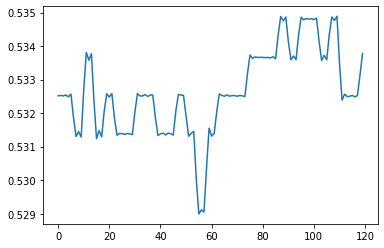

In [281]:
df["TEMP"].plot()